In [1]:
import numpy as np
from PIL import Image
from IPython.display import Image as im, display

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
maxCRef = np.array([1.9705, 1.0308])


In [3]:
def standardize_brightness(img):
    p = np.percentile(img,90)
    return np.clip(img * 255.0 / p, 0, 255).astype(np.uint8)

In [4]:
def RGB_to_OD(img, Io = 255):    
    return - np.log((img + 1e-6)/ Io)

def OD_to_RGB(OD, Io = 255):
    return (Io* np.exp(-OD))
   

In [5]:


def normalize_stain(img,Io = 255,alpha = 1,beta = 0.15, saveFile = None):
    
    img = standardize_brightness(img)
    
    #get image parameters h =height, w = width, c = channels
    h,w,c = img.shape
    
    #reshape an image to a shape 
    reshaped_img = np.reshape(img.astype(np.float), (-1,3))

    #calculate Optical Density 
    
    OD = RGB_to_OD(reshaped_img,Io = Io)
    
    #remove pixels with threshold = beta
    OD_reduced = np.array([i for i in OD if not any(i<beta)])
    
    #calculate SVD on the OD tuples
    U,S,V = np.linalg.svd(np.cov(OD_reduced.T))
    
    #project on the plane spanned by the e SVD directions corresponding to the
    #two largest singular values
    
    T = OD_reduced.dot(V[:,0:2])
    #print(T)
    
    phi = np.arctan2(T[:,1], T[:,0])
    
    min_phi = np.percentile(phi,alpha)
    max_phi = np.percentile(phi,100-alpha)
    
    vMin = V[:,0:2].dot(np.array([(np.cos(min_phi), np.sin(min_phi))]).T)
    vMax = V[:,0:2].dot(np.array([(np.cos(max_phi), np.sin(max_phi))]).T)
    
    
    #rearange so that first vector corresponds to hematoxylin
    #and second vector corresponds to eosin
    
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    C_normalized = np.array([C[:,i]/maxC*maxCRef for i in range(C.shape[1])]).T
    
    
    # recreate the image using reference mixing matrix
    I_normalized = np.multiply(Io, np.exp(-HERef.dot(C_normalized)))
    I_normalized[I_normalized>255] = 255
    I_normalized = np.reshape(I_normalized.T, (h, w, 3)).astype(np.uint8)  
    
    
    
    #separate hametoxylin and eosin matrices
    #H = Io* np.exp(-np.expand_dims(HERef[:,0], axis=1).dot(np.expand_dims(C_normalized[0,:], axis=0)))
    H_OD = np.expand_dims(HERef[:,0], axis=1).dot(np.expand_dims(C_normalized[0,:], axis=0))
    H = OD_to_RGB(H_OD,Io = Io)
    H[H>255] = 255
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    #E = Io* np.exp(-np.expand_dims(HERef[:,1], axis=1).dot(np.expand_dims(C_normalized[1,:], axis=0)))
    
    E_OD = np.expand_dims(HERef[:,1], axis=1).dot(np.expand_dims(C_normalized[1,:], axis=0))
    E = OD_to_RGB(E_OD,Io = Io)
    E[E>255] = 255
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    #save all normalized images
    
    if saveFile is not None:
        Image.fromarray(I_normalized).save(saveFile+'.png')
        Image.fromarray(H).save(saveFile+'_H.png')
        Image.fromarray(E).save(saveFile+'_E.png')
    
    
    
    return I_normalized, H, E
    

In [6]:
def scale_image(img, scale_type = 'normalize'):
     
    """
    Scales the image according to scale_type
    
    Arguments:
        img: image given as np.array
        scale_type: type of scaling, possible values {'normalize', 'loc_center','center', 'standardize'}
    
    Returns:
        scaled_img: scaled image
    
    """
    assert scale_type in ('normalize','loc_center','center','standardize')
    
    scaled_img = img.astype('float32')
    
    if scale_type == 'normalize':
        scaled_img= scaled_img / 255
        
    if scale_type == 'loc_center':
        scaled_img = img - img.mean()
    
    if scale_type == 'loc_center':
        # this is local centering,  per-channel centering
        scaled_img = img - img.mean(axis=(0,1), dtype='float64')
    
    if scale_type == 'standardize':
        scaled_img = (img - img.mean())/img.std()
    
    return scaled_img

In [7]:
def show_images(img_in):
    
    """
    Displays initial image, normalized image, Hematoxylin stain and Eosin stain
    
    Arguments:
        img_in: initial image given as np.array
    
    """
    
    I_normalized, H, E = normalize_stain(img_in)
    img = Image.fromarray(I_normalized, 'RGB')
    img_H = Image.fromarray(H, 'RGB')
    img_E = Image.fromarray(E, 'RGB')
    
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    fig.suptitle("Example",fontsize = 15)
    plt.setp(ax, xticks=[], yticks=[])
    
    ax[0].set_title('Input image', fontsize = 10)
    ax[1].set_title('Normalized image',fontsize=10)
    ax[2].set_title('Hematoxylin stain',fontsize=10)
    ax[3].set_title('Eosin stain',fontsize=10)
    
    ax[0].imshow(img_in)
    ax[1].imshow(img)
    ax[2].imshow(img_H)
    ax[3].imshow(img_E)

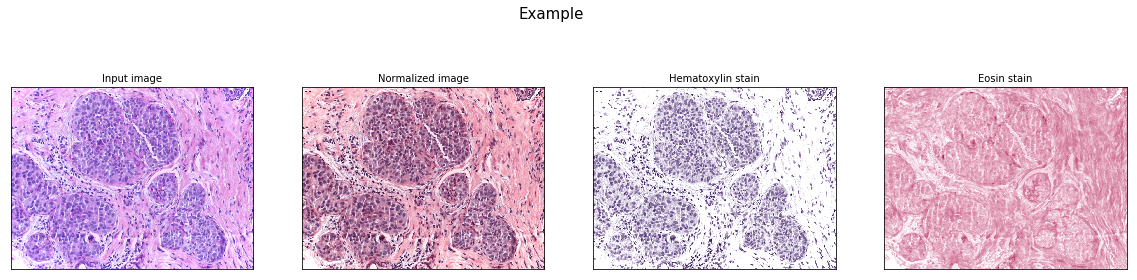

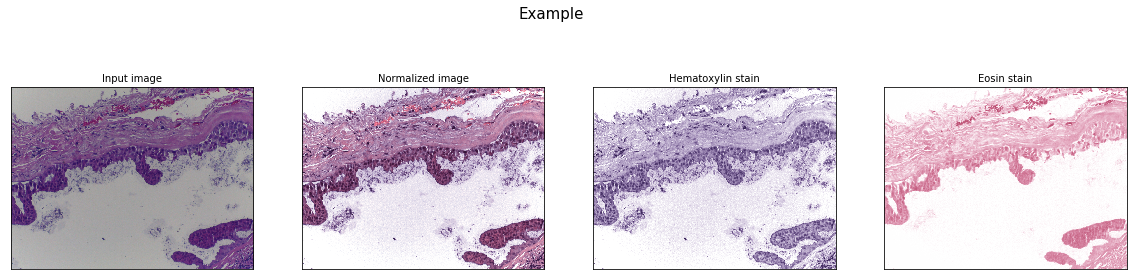

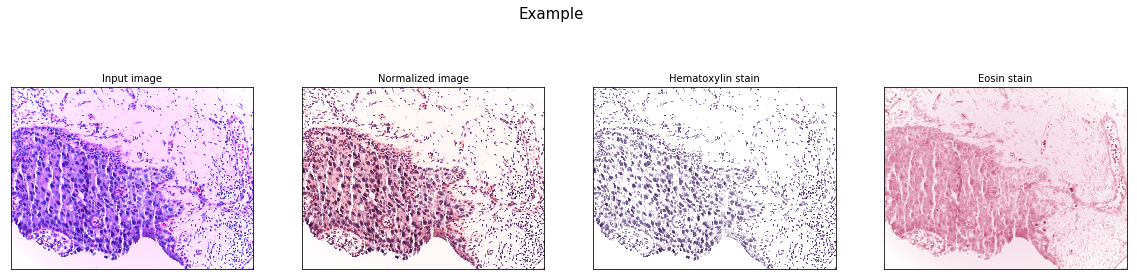

In [8]:
if __name__=='__main__':
    
    img = np.array(Image.open('t0.tif'))
    show_images(img)
    
    img = np.array(Image.open('t43.tif'))
    show_images(img)
    
    img = np.array(Image.open('t59.tif'))
    show_images(img)
    
